In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.transform import rotate, resize
import mrcfile
import os, sys
import logging

### Intensity Thresholding for subtomogram extraction/ particle picking
Code is from IsoNET

In [28]:
def maxmask(tomo, side=5,percentile=60):
    from scipy.ndimage import maximum_filter
    # print('maximum_filter')
    filtered = maximum_filter(-tomo, 2*side+1, mode='reflect')
    out =  filtered > np.percentile(filtered, 100-percentile)
    out = out.astype(np.uint8)
    return out

def stdmask(tomo, side=10, threshold=60):
    from scipy.signal import convolve
    # print('std_filter')
    tomosq = tomo**2
    ones = np.ones(tomo.shape)
    eps = 0.001
    kernel = np.ones((2*side+1, 2*side+1, 2*side+1))
    s = convolve(tomo, kernel, mode="same")
    s2 = convolve(tomosq, kernel, mode="same")
    ns = convolve(ones, kernel, mode="same") + eps

    out = np.sqrt((s2 - s**2 / ns) / ns + eps)
    # out = out>np.std(tomo)*threshold
    out  = out>np.percentile(out, 100-threshold)
    return out.astype(np.uint8)

def make_mask(tomogram: np.array,
              patch_size: int = 4,
              density_percentage: float = 50.,
              std_percentage:float = 50.,
              z_crop:float = None):
    """
    patch_size: size of the box from which the max-filter and std-filter are created
    z_crop: If exclude the top and bottom regions of tomograms along z axis. 
            For example, "--z_crop 0.2" will mask out the top 20% and bottom 20% region along z axis.
    """
    size = np.array(tomogram.shape)
    sp2 = size // 2
    bintomo = resize(tomogram, sp2, anti_aliasing = True)
    gauss = gaussian_filter(bintomo, patch_size/2)
    
    if density_percentage <=99.8:
        mask1 = maxmask(gauss, side= patch_size, percentile=density_percentage)
    else:
        mask1 = np.ones(sp2)

    if std_percentage <=99.8:
        mask2 = stdmask(gauss, side= patch_size, threshold=std_percentage)
    else:
        mask2 = np.ones(size2)

    out_mask_bin = np.multiply(mask1,mask2)


    if (z_crop is not None) and z_crop < 1:
        for i in range(int(z_crop *sp2[0])):
            out_mask_bin[i] = 0
        for i in range(int((1- z_crop)*sp2[0]),sp2[0]):
            out_mask_bin[i] = 0


    out_mask = np.zeros(size)
    out_mask[0:-1:2,0:-1:2,0:-1:2] = out_mask_bin
    out_mask[0:-1:2,0:-1:2,1::2] = out_mask_bin
    out_mask[0:-1:2,1::2,0:-1:2] = out_mask_bin
    out_mask[0:-1:2,1::2,1::2] = out_mask_bin
    out_mask[1::2,0:-1:2,0:-1:2] = out_mask_bin
    out_mask[1::2,0:-1:2,1::2] = out_mask_bin
    out_mask[1::2,1::2,0:-1:2] = out_mask_bin
    out_mask[1::2,1::2,1::2] = out_mask_bin
    out_mask = (out_mask>0.5).astype(np.uint8)
    
    return out_mask

In [17]:
even_rec = mrcfile.read('/global/cfs/projectdirs/xray/kpande/et_denoising/ribosome/total_noise_50K_mag_75K/full.mrc')
even_rec = np.array(even_rec)
print(even_rec.shape)

(200, 2000, 2000)


In [18]:
even_rec = np.array(even_rec)

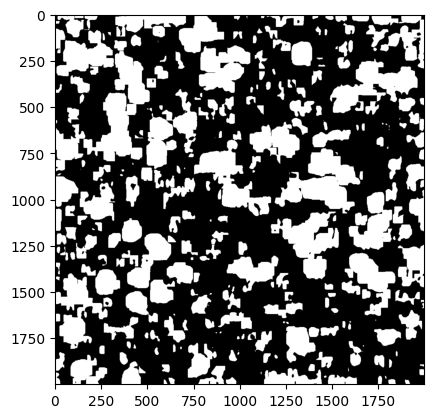

In [109]:
mask10 = make_mask(even_rec, patch_size = 10, std_percentage = 50.)
plt.imshow(mask10[100,:,:], cmap = 'gray')

In [48]:
mask = make_mask(even_rec, patch_size = 4, std_percentage = 50.)

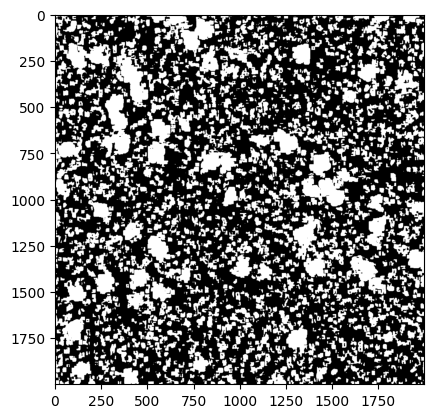

In [49]:
plt.imshow(mask[100,:,:], cmap = 'gray')

## Higher Noise dataset

In [4]:
full_rec_10k = torch.Tensor(mrcfile.read('/global/cfs/projectdirs/xray/kpande/et_denoising/ribosome/total_dose_10K_mag75K/full_rec.mrc'))
even_rec_10k = torch.Tensor(mrcfile.read('/global/cfs/projectdirs/xray/kpande/et_denoising/ribosome/total_dose_10K_mag75K/even_rec.mrc'))


In [5]:
full_mask = make_mask(full_rec_10k)
even_mask = make_mask(even_rec_10k)

In [6]:
print(full_mask.shape, even_mask.shape)

(2000, 200, 2000) (2000, 200, 2000)


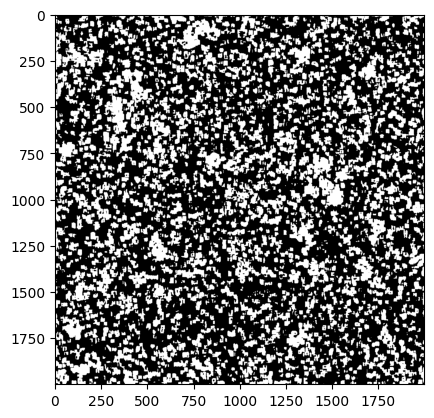

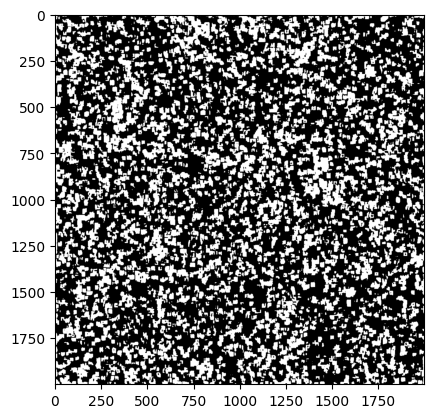

In [8]:
plt.imshow(full_mask[:,100,:], cmap = 'gray')
plt.show()
plt.imshow(even_mask[:,100,:], cmap = 'gray')

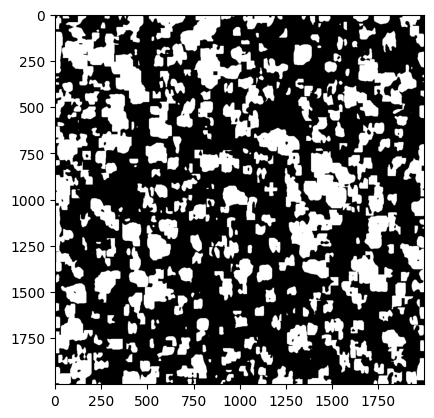

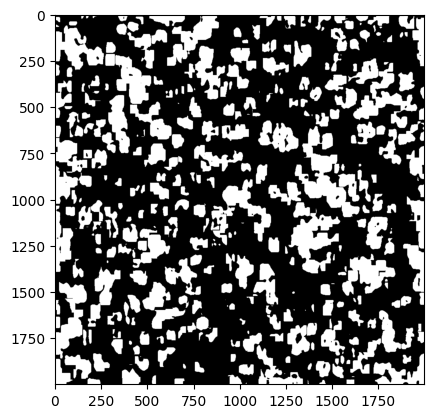

In [9]:
full_mask_10 = make_mask(full_rec_10k, patch_size = 10)
even_mask_10 = make_mask(even_rec_10k, patch_size = 10)
plt.imshow(full_mask_10[:,100,:], cmap = 'gray')
plt.show()
plt.imshow(even_mask_10[:,100,:], cmap = 'gray')

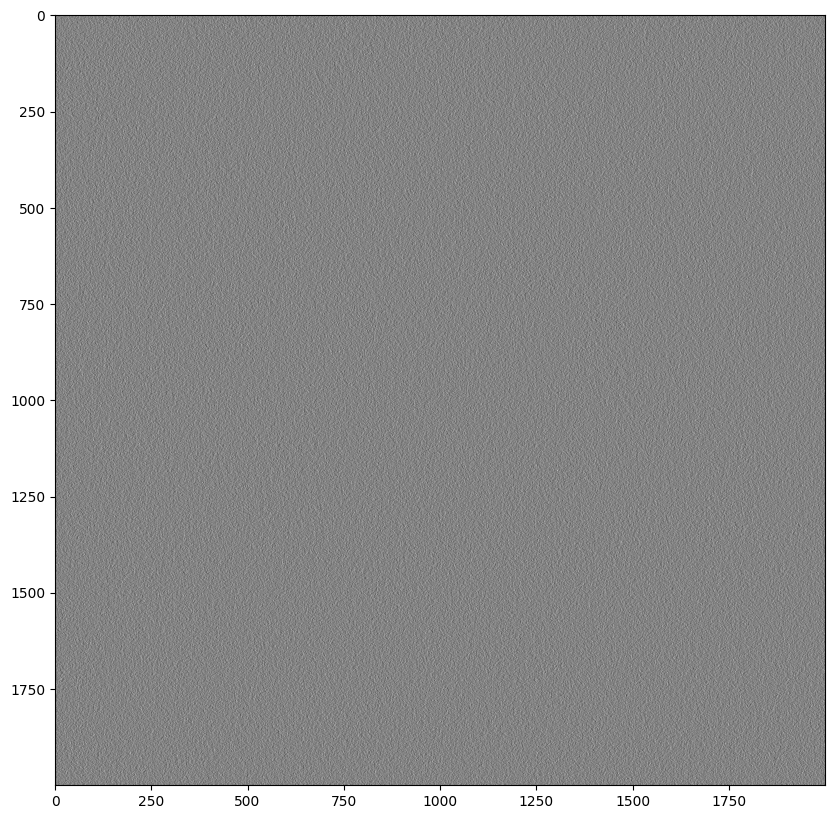

In [18]:
plt.imshow(even_rec_10k[:,100,:], cmap = 'gray')
plt.gcf().set_size_inches(w = 10, h = 10)

In [10]:
ground = np.array(mrcfile.read('/global/cfs/projectdirs/xray/kpande/et_denoising/ribosome/noise_free/noisefree_full_rec.mrc'))

(2000, 200, 2000)


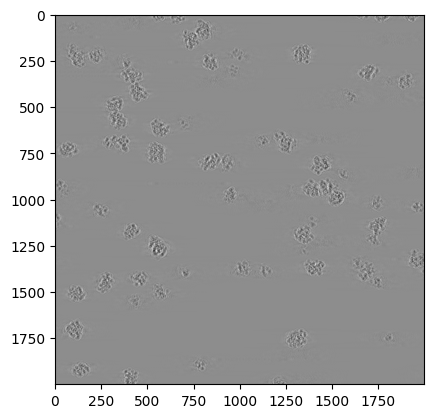

In [12]:
print(ground.shape)
plt.imshow(ground[:,100,:], cmap = 'gray')

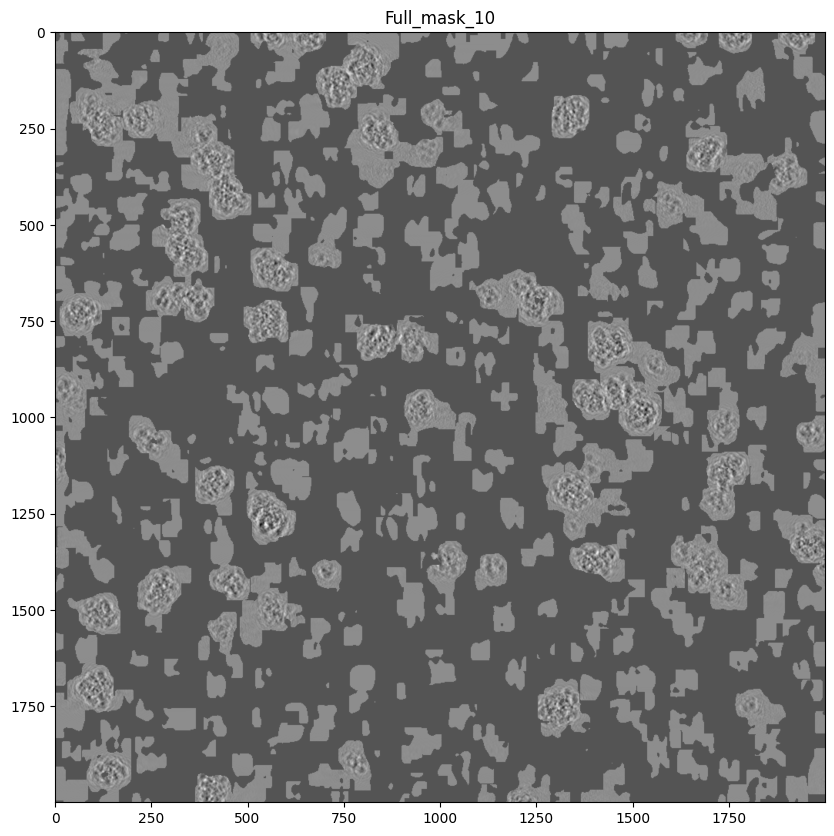

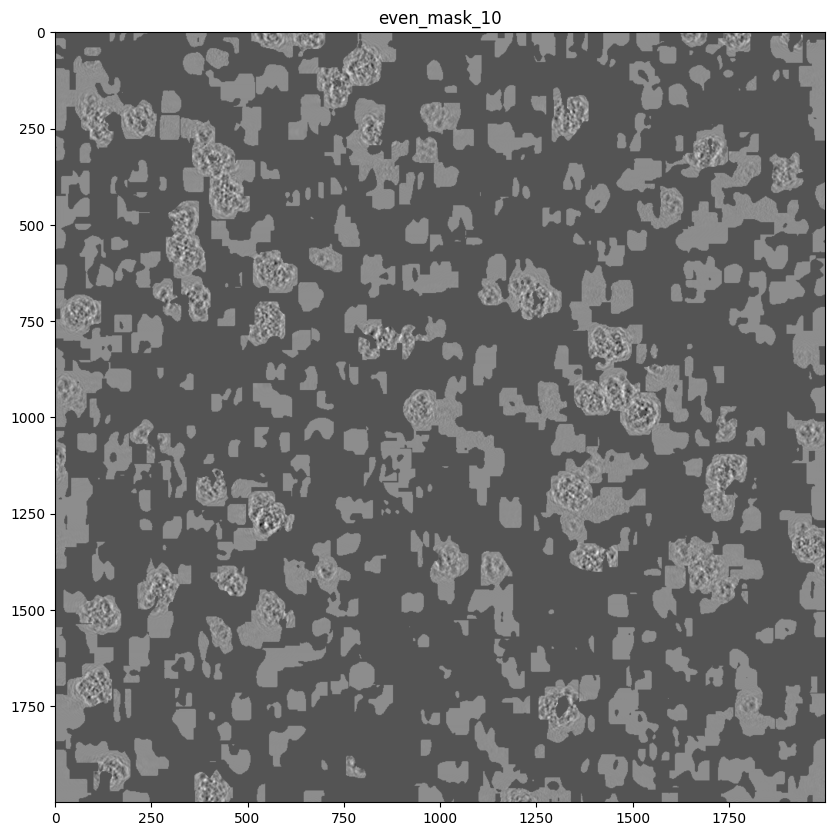

In [24]:
plt.imshow(ground[:,100,:] * full_mask_10[:,100,:], cmap = 'gray')
plt.gcf().set_size_inches(w = 10, h = 10)
plt.title('Full_mask_10')
plt.show()
plt.imshow(ground[:,100,:] * even_mask_10[:,100,:], cmap = 'gray')
plt.gcf().set_size_inches(w = 10, h = 10)
plt.title('even_mask_10')
plt.show()

Text(0.5, 1.0, '1 - full mask width 10')

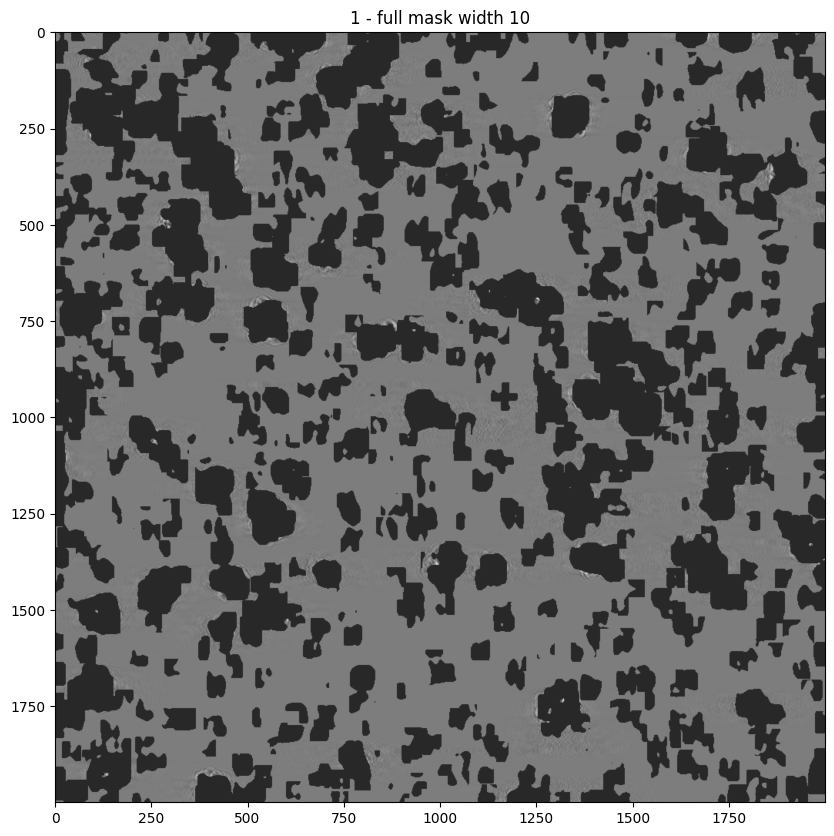

In [33]:
plt.imshow(ground[:,100,:] * (1 - full_mask_10[:,100,:]), cmap = 'gray')
plt.gcf().set_size_inches(w = 10, h = 10)
plt.title('1 - full mask width 10')

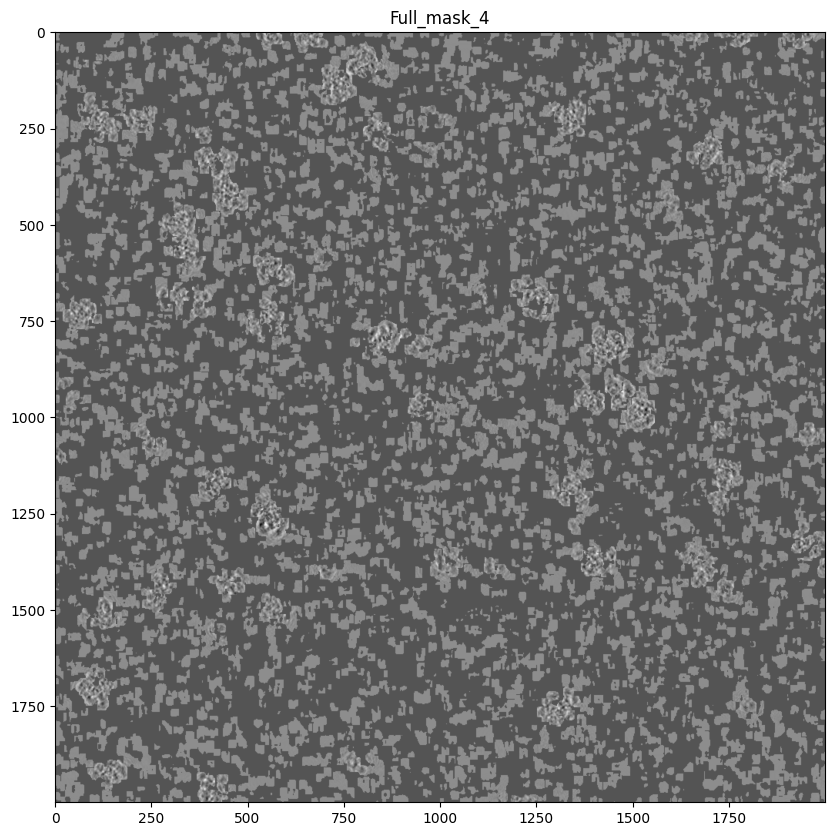

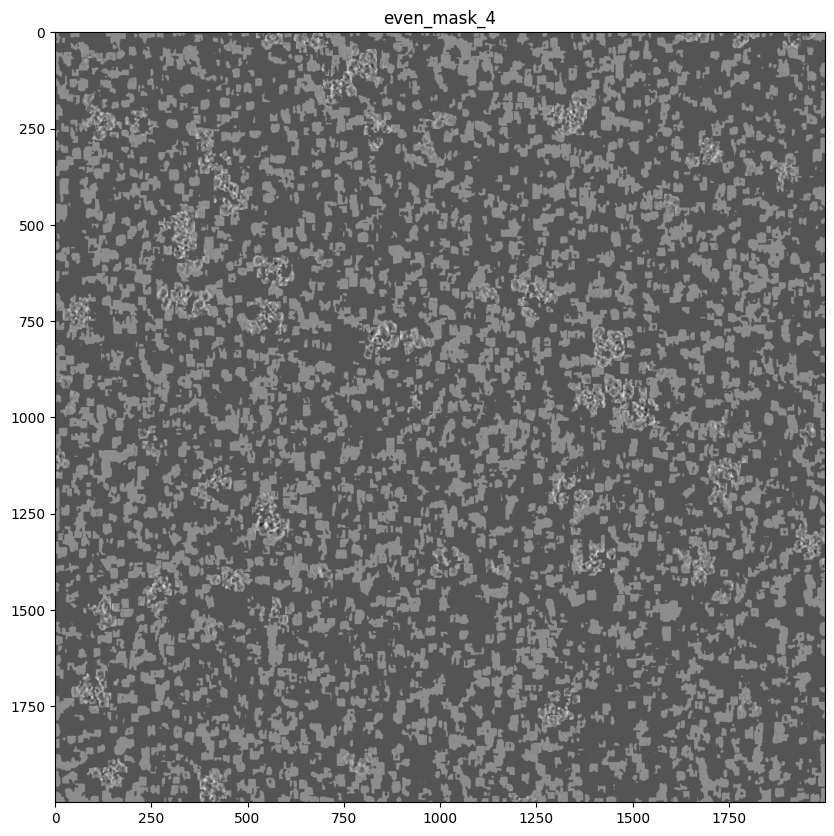

In [34]:
plt.imshow(ground[:,100,:] * full_mask[:,100,:], cmap = 'gray')
plt.gcf().set_size_inches(w = 10, h = 10)
plt.title('Full_mask_4')
plt.show()
plt.imshow(ground[:,100,:] * even_mask[:,100,:], cmap = 'gray')
plt.gcf().set_size_inches(w = 10, h = 10)
plt.title('even_mask_4')
plt.show()

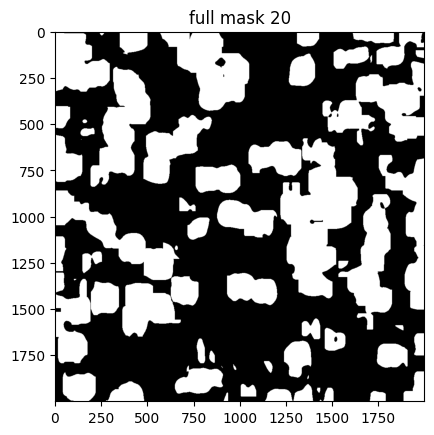

Text(0.5, 1.0, 'even mask 20')

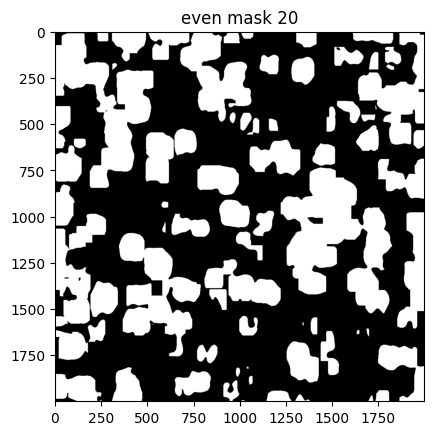

In [35]:
full_mask_20 = make_mask(full_rec_10k, patch_size = 20)
even_mask_20 = make_mask(even_rec_10k, patch_size = 20)
plt.imshow(full_mask_20[:,100,:], cmap = 'gray')
plt.title('full mask 20')
plt.show()
plt.imshow(even_mask_20[:,100,:], cmap = 'gray')
plt.title('even mask 20')

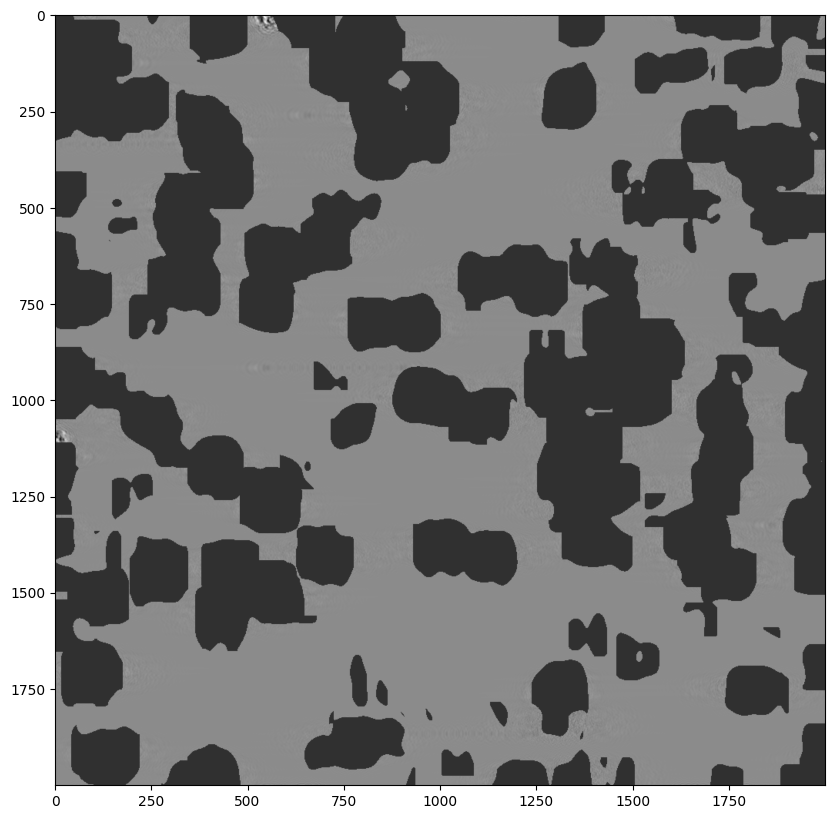

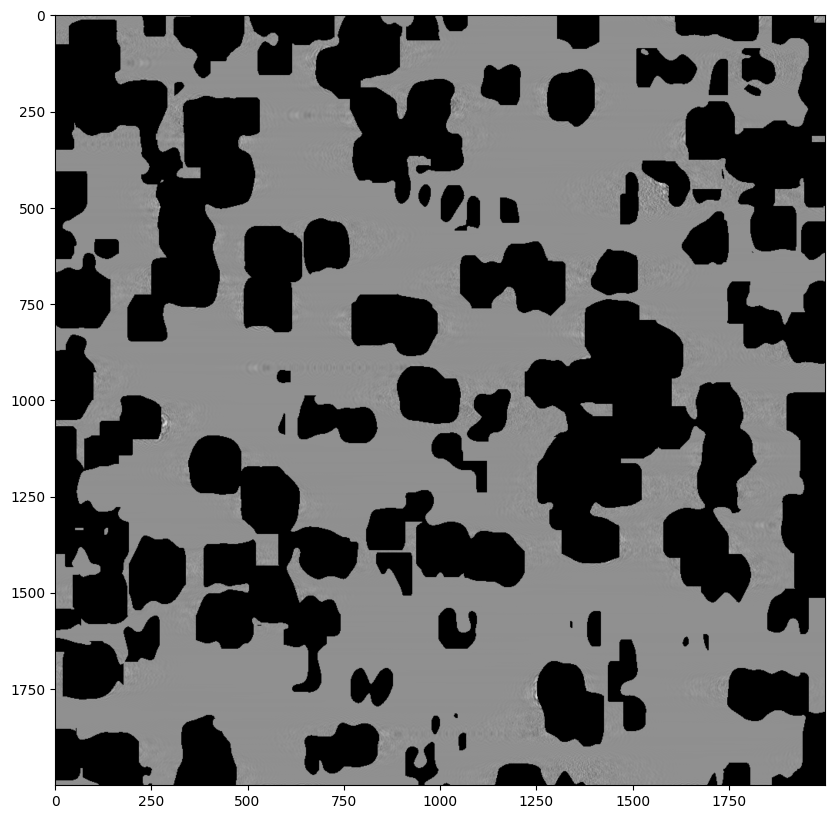

In [29]:
plt.imshow(ground[:,100,:] * (1 - full_mask_20[:,100,:]), cmap = 'gray')
plt.gcf().set_size_inches(w = 10, h = 10)
plt.show()
plt.imshow(ground[:,100,:] * (1 - even_mask_20[:,100,:]), cmap = 'gray')
plt.gcf().set_size_inches(w = 10, h = 10)
plt.show()

## This seems to be our best mask when we compare with the noise free tomogram
The full mask is better than the even as expected.

In [30]:
full_mask_30 = make_mask(full_rec_10k, patch_size = 30)
even_mask_30 = make_mask(even_rec_10k, patch_size = 30)

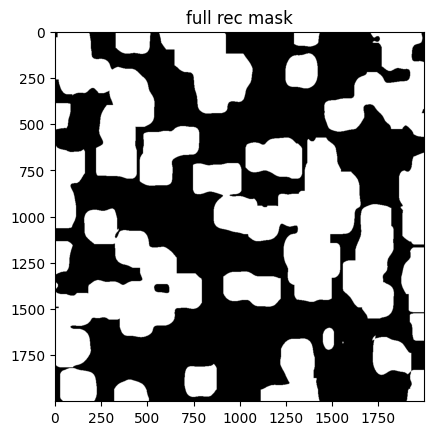

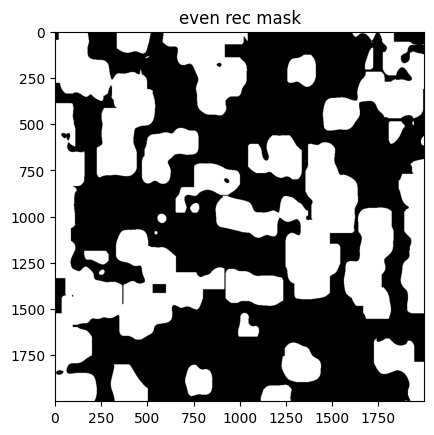

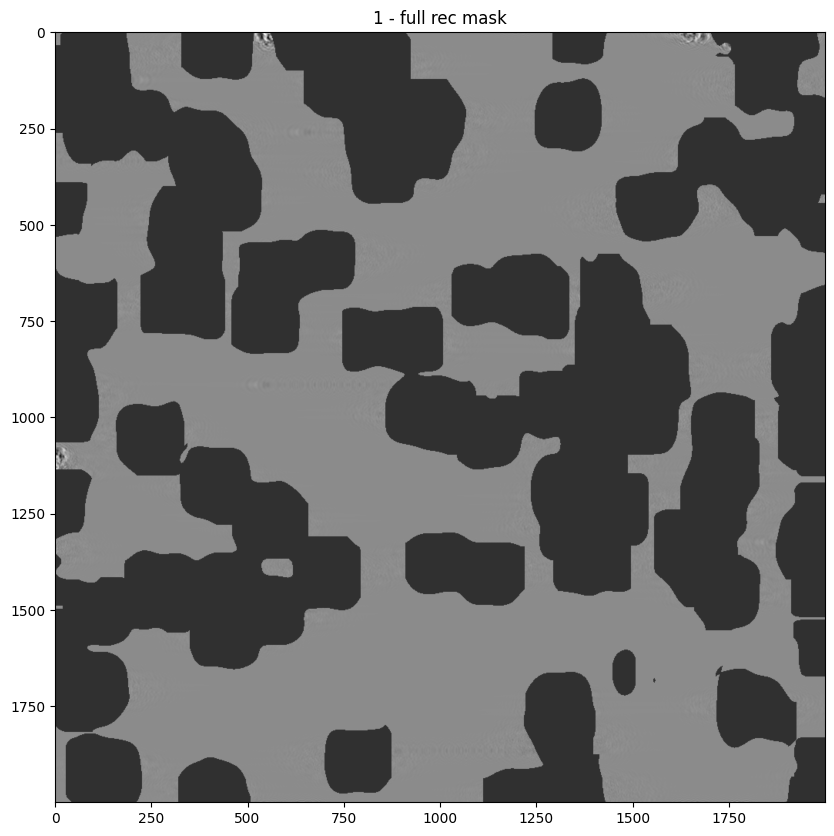

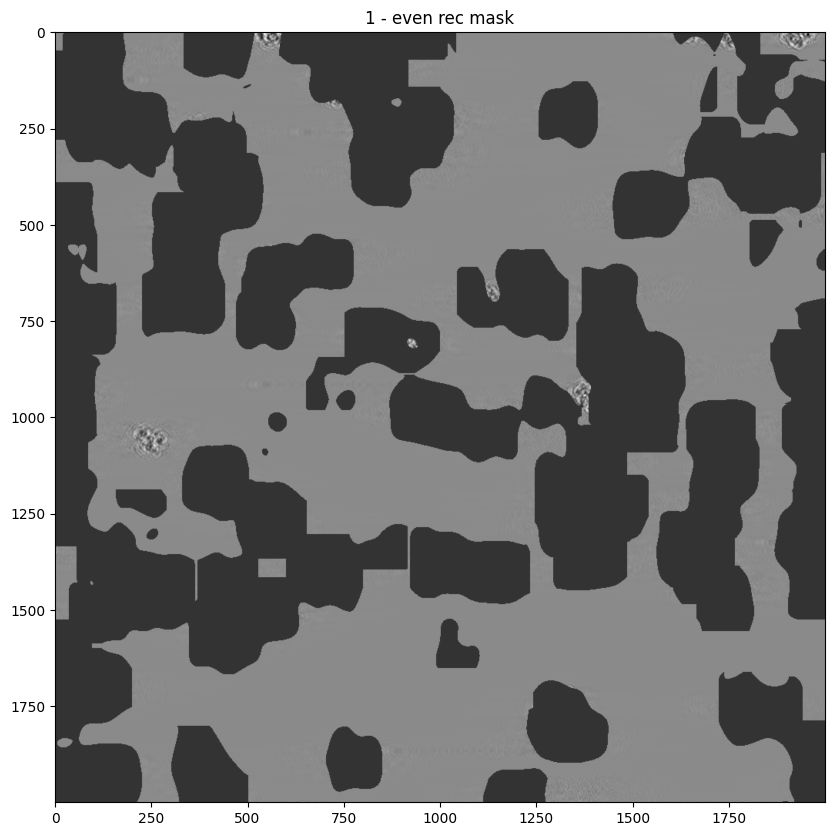

In [31]:
plt.imshow(full_mask_30[:,100,:], cmap = 'gray')
plt.title('full rec mask')
plt.show()
plt.imshow(even_mask_30[:,100,:], cmap = 'gray')
plt.title('even rec mask')
plt.show()
plt.imshow(ground[:,100,:] * (1 - full_mask_30[:,100,:]), cmap = 'gray')
plt.gcf().set_size_inches(w = 10, h = 10)
plt.title('1 - full rec mask')
plt.show()
plt.imshow(ground[:,100,:] * (1 - even_mask_30[:,100,:]), cmap = 'gray')
plt.gcf().set_size_inches(w = 10, h = 10)
plt.title('1 - even rec mask')
plt.show()

In [36]:
#mrc = mrcfile.new("best_10k_mask_30w.mrc")
#mrc.set_data(full_mask_30.astype(np.float32))
#mrc.close()